In [1]:
from vision.seem_module.modeling.BaseModel import BaseModel
from vision.seem_module.modeling import build_model
from vision.seem_module.utils.arguments import load_opt_from_config_files
from vision.seem_module.utils.constants import COCO_PANOPTIC_CLASSES
from vision.seem_module.utils.distributed import init_distributed
from vision.seem_module.utils.visualizer import Visualizer 

import sys
sys.path.append('/cmlscratch/nehamk/RelateAnything')

from vision.relate_anything.segment_anything import build_sam, SamPredictor, SamAutomaticMaskGenerator
from vision.relate_anything.utils import iou, sort_and_deduplicate, relation_classes, MLP, show_anns, show_mask
from vision.relate_anything.ram_train_eval import RamModel,RamPredictor

import os
import torch 
from detectron2.utils.colormap import random_color
from detectron2.data import MetadataCatalog
from detectron2.structures import BitMasks
from PIL import Image
from torchvision import transforms 
import numpy as np 
import matplotlib.pyplot as plt 

from mmengine.config import Config


/nfshomes/snawathe/micromamba/envs/dense-image-representations/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Deformable Transformer Encoder is not available.


/nfshomes/snawathe/micromamba/envs/dense-image-representations/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
conf_files = 'vision/seem_module/configs/seem/focall_unicl_lang_demo.yaml'
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

# META DATA
cur_model = 'None'
if 'focalt' in conf_files:
    pretrained_pth = os.path.join("seem_focalt_v0.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focalt_v0.pt"))
    cur_model = 'Focal-T'
elif 'focal' in conf_files:
    pretrained_pth = os.path.join("seem_focall_v1.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focall_v1.pt"))
    cur_model = 'Focal-L'

'''
build model
'''
# model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval()
with torch.no_grad():
    thing_colors = [random_color(rgb=True, maximum=255).astype(np.int32).tolist() for _ in range(len(COCO_PANOPTIC_CLASSES))]
    thing_dataset_id_to_contiguous_id = {x:x for x in range(len(COCO_PANOPTIC_CLASSES))}
    
    MetadataCatalog.get("demo").set(
        thing_colors=thing_colors,
        thing_classes=COCO_PANOPTIC_CLASSES,
        thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
    )
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(COCO_PANOPTIC_CLASSES + ["background"], is_eval=False)
    metadata = MetadataCatalog.get('demo')
    model.model.metadata = metadata
    model.model.sem_seg_head.num_classes = len(COCO_PANOPTIC_CLASSES)

/cmlscratch/snawathe/dense-image-representations/dense-image-representations/vision/seem_module/modeling/BaseModel.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load ram model
model_path = "/cmlscratch/snawathe/dense-image-representations/training_output_alt/epoch_10.pth"
config = dict(
    model=dict(
        pretrained_model_name_or_path='bert-base-uncased',
        load_pretrained_weights=False,
        num_transformer_layer=2,
        input_feature_size=512,
        output_feature_size=768,
        cls_feature_size=512,
        num_relation_classes=56,
        pred_type='attention',
        loss_type='multi_label_ce',
    ),
    load_from=model_path,
)
config = Config(config)

class Predictor(RamPredictor):
    def __init__(self,config):
        self.config = config
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self._build_model()

    def _build_model(self):
        self.model = RamModel(**self.config.model).to(self.device)
        if self.config.load_from is not None:
            self.model.load_state_dict(torch.load(self.config.load_from, map_location=self.device), strict=False)
        # self.model.train()
        self.model.eval()

ram_predictor = Predictor(config)

Use Multi Label Cross Entropy Loss.


/tmp/ipykernel_242659/1298998415.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.config.load_from, map_location=self.device),

In [4]:
import glob
glob.glob('/fs/cml-datasets/coco/images/train2017/*.jpg')

['/fs/cml-datasets/coco/images/train2017/000000495546.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000377589.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000248732.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000327130.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000576483.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000163192.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000059335.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000087141.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000146773.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000056664.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000020136.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000467135.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000581863.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000281246.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000291141.jpg',
 '/fs/cml-datasets/coco/images/train2017/000000145163.jpg',
 '/fs/cml-datasets/coco/images/train2017

In [5]:
transform = transforms.Compose([
                transforms.Resize((512, 512), interpolation=Image.BICUBIC),
                transforms.PILToTensor()
            ])

image_ori = Image.open('person_with_coffee.jpeg').convert("RGB")
# image_ori = Image.open('/fs/cml-datasets/coco/images/train2017/000000000009.jpg').convert("RGB")

width = image_ori.size[0]
height = image_ori.size[1]
image = transform(image_ori)
image_ori = np.asarray(image_ori)

batch_inputs = [{'image': image, 'height': height, 'width': width}]

with torch.no_grad():
    outputs = model.forward(batch_inputs)

In [6]:
visual = Visualizer(image_ori, metadata=metadata)

inst_seg = outputs[-1]['instances']
inst_seg.pred_masks = inst_seg.pred_masks.cpu()
inst_seg.pred_boxes = BitMasks(inst_seg.pred_masks > 0).get_bounding_boxes()
demo = visual.draw_instance_predictions(inst_seg) # rgb Image

demo.save('inst_1.png')


In [7]:
sel_inst_seg = inst_seg[(inst_seg.scores > 0.5).cpu()]
masks = BitMasks(sel_inst_seg.pred_masks > 0)
bboxes = masks.get_bounding_boxes()

[COCO_PANOPTIC_CLASSES[i] for i in sel_inst_seg.pred_classes]

['person', 'bench', 'tree-merged', 'book', 'pavement-merged', 'grass-merged']

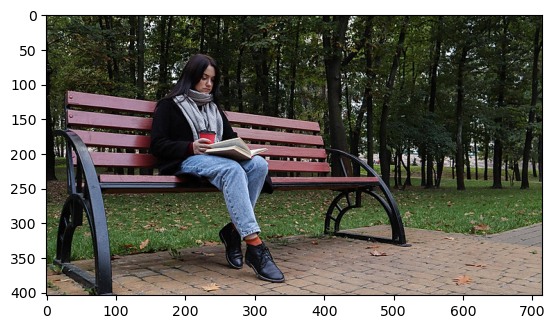

In [8]:
plt.imshow(image_ori)

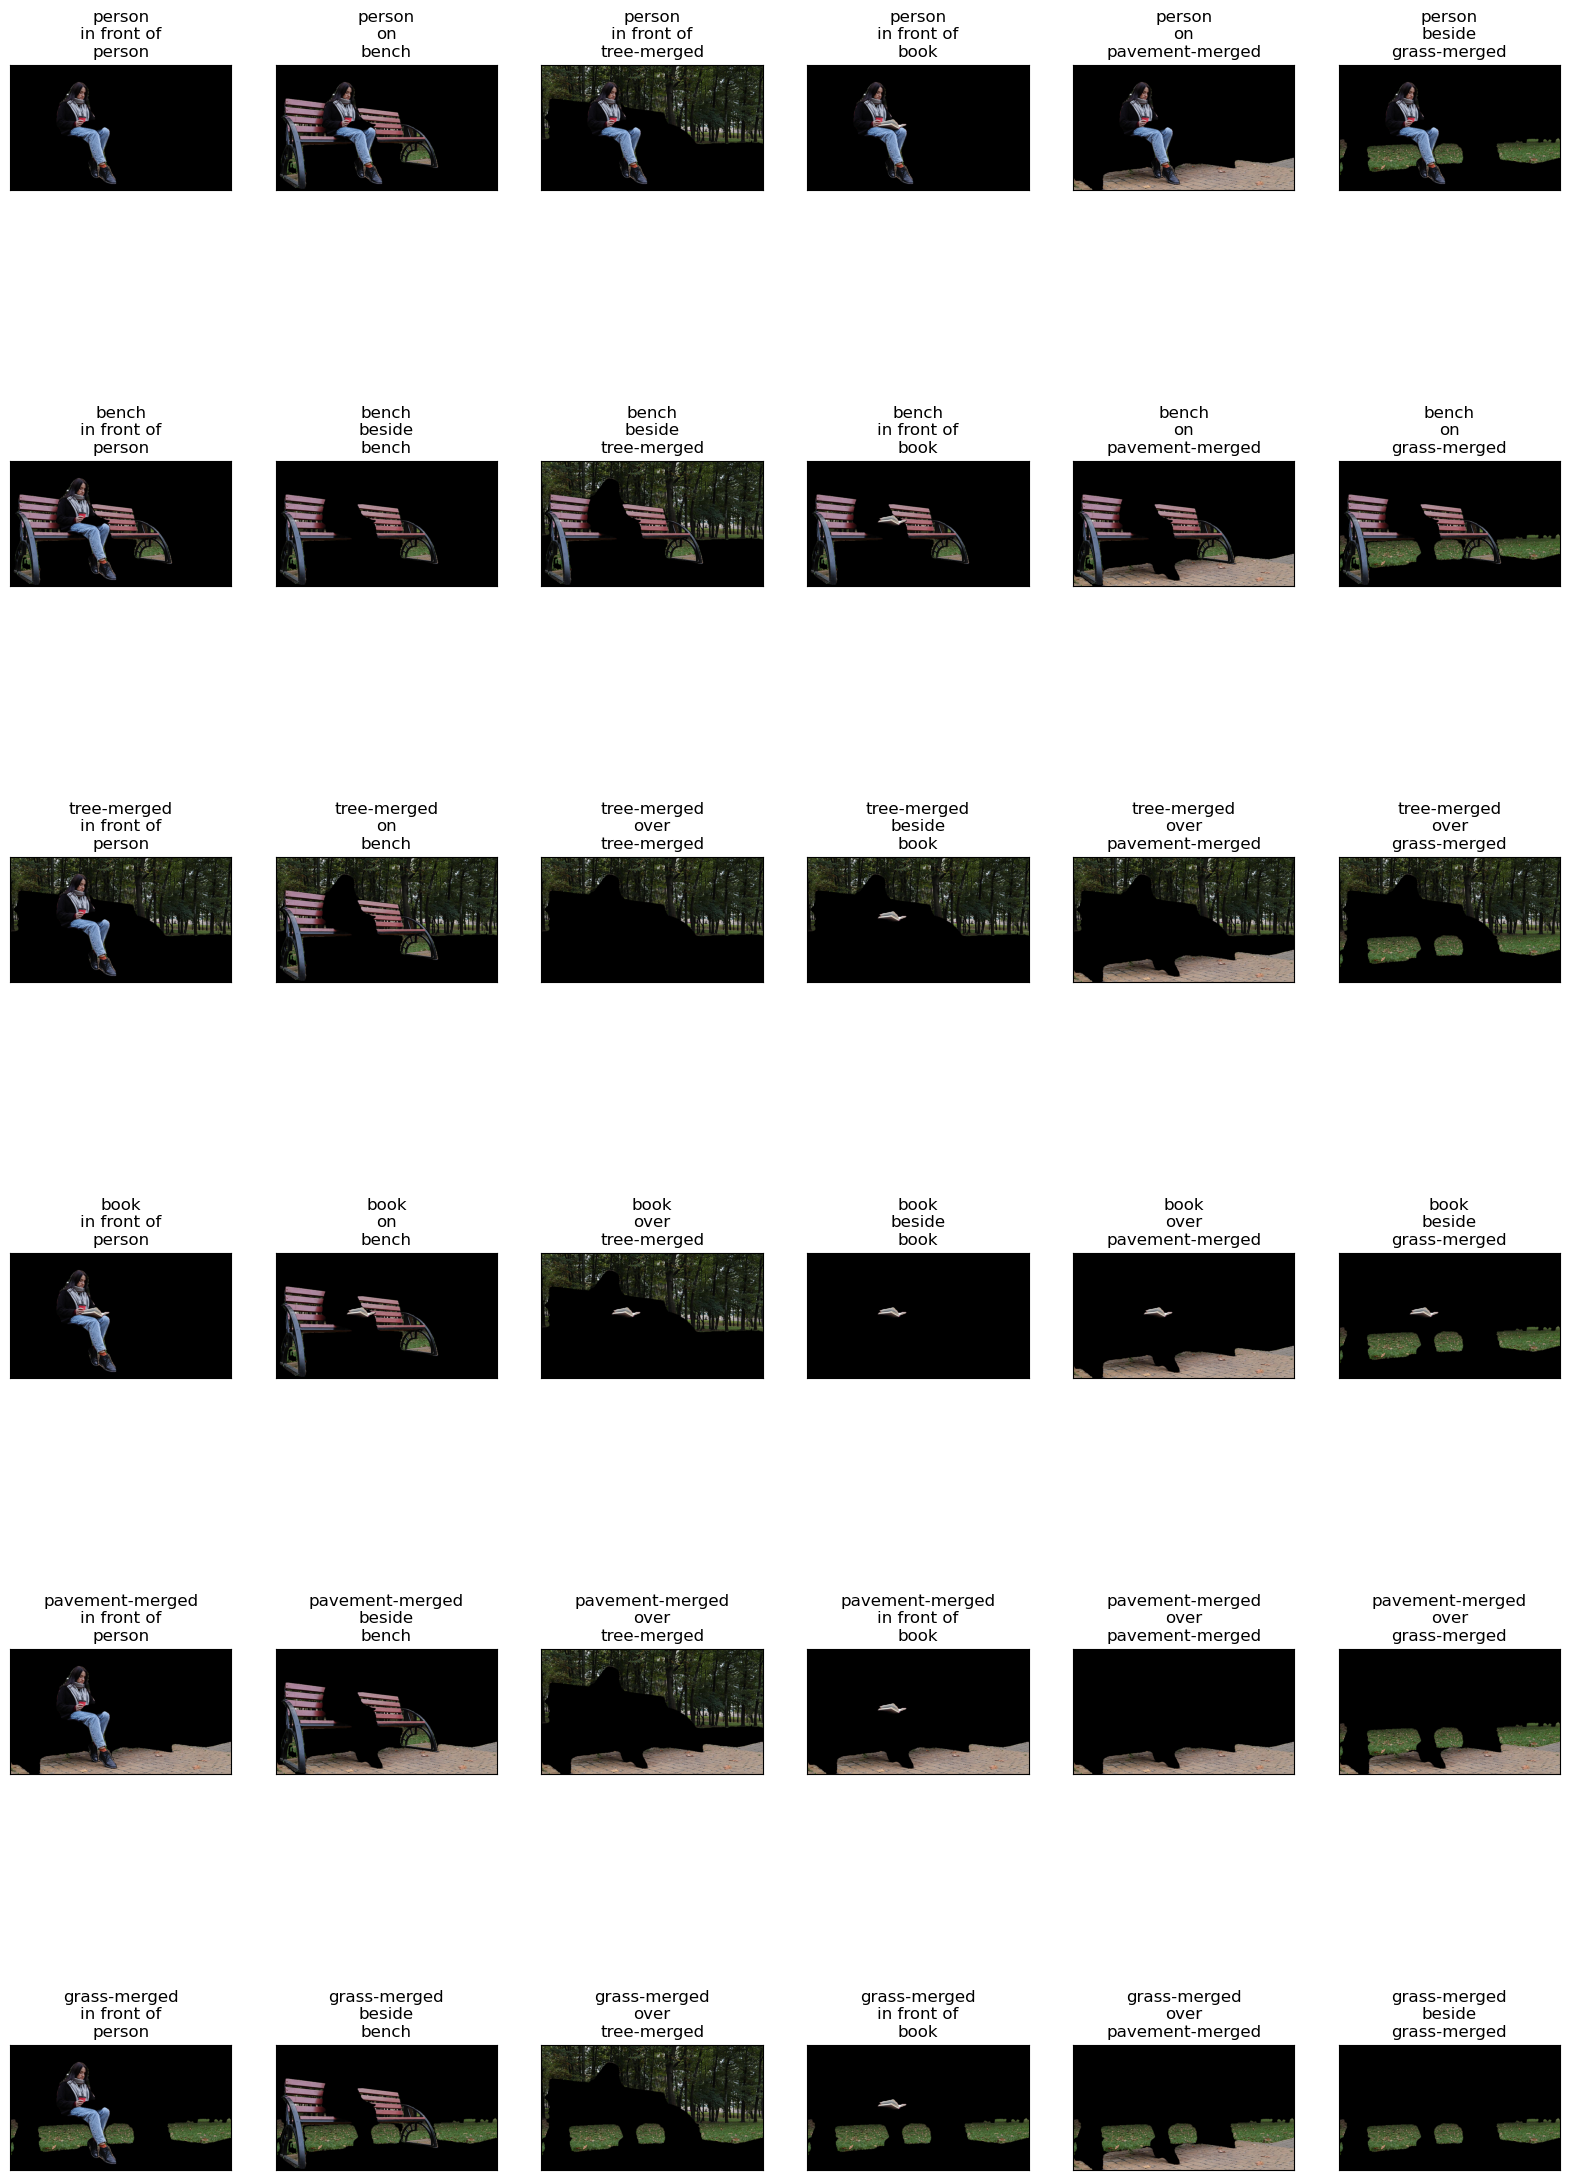

In [9]:
fig, ax = plt.subplots(bboxes.tensor.shape[0], bboxes.tensor.shape[0], figsize = (20, 30))

for b1, feat1, mask1 in zip(range(bboxes.tensor.shape[0]), sel_inst_seg.pred_mask_embs, sel_inst_seg.pred_masks):
    for b2, feat2, mask2 in zip(range(bboxes.tensor.shape[0]), sel_inst_seg.pred_mask_embs, sel_inst_seg.pred_masks):
        feat = torch.cat((feat1[torch.newaxis, torch.newaxis, :], feat2[torch.newaxis, torch.newaxis, :]), dim=1)
        matrix_output, rel_triplets = ram_predictor.predict(feat)
            
        subject_output = matrix_output.permute([0,2,3,1])[:,0,1:]
        
        output = subject_output[:,0]
        topk_indices = torch.argsort(-output).flatten()
        relation = relation_classes[topk_indices[:1][0]]

        if -torch.sort(-output).values.flatten()[:1].item() > 0.005 and b1 != b2:
            print(f'{COCO_PANOPTIC_CLASSES[sel_inst_seg.pred_classes[b1]]} {relation} {COCO_PANOPTIC_CLASSES[sel_inst_seg.pred_classes[b2]]}')
        
        combined_mask = np.maximum(mask1.numpy(), mask2.numpy())
        combined_mask = np.stack((combined_mask, combined_mask, combined_mask), axis=-1)
        ax[b1][b2].imshow(image_ori * combined_mask / 255.0)
        ax[b1][b2].set_title(f'{COCO_PANOPTIC_CLASSES[sel_inst_seg.pred_classes[b1]]}\n{relation}\n{COCO_PANOPTIC_CLASSES[sel_inst_seg.pred_classes[b2]]}')
        ax[b1][b2].set_xticks([])
        ax[b1][b2].set_yticks([])